In [37]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

import matplotlib.pyplot as plt

from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [38]:
# Define the transform with normalization
transform = transforms.ToTensor()
    

# Load the full training and test datasets
full_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=transform
)

full_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=transform
)

# Define the number of samples you want to use
num_train_samples = 10000
num_test_samples = 2000

# Create subsets of the data
train_indices = np.random.choice(len(full_training_data), num_train_samples, replace=False)
test_indices = np.random.choice(len(full_test_data), num_test_samples, replace=False)

training_data = Subset(full_training_data, train_indices)
test_data = Subset(full_test_data, test_indices)

# Create data loaders

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Check the dtype of the images
sample_image, _ = next(iter(train_dataloader))
print(f"Training data sample dtype: {sample_image.dtype}")

sample_image, _ = next(iter(test_dataloader))
print(f"Test data sample dtype: {sample_image.dtype}")

Training data sample dtype: torch.float32
Test data sample dtype: torch.float32


In [39]:
len(test_data)

2000

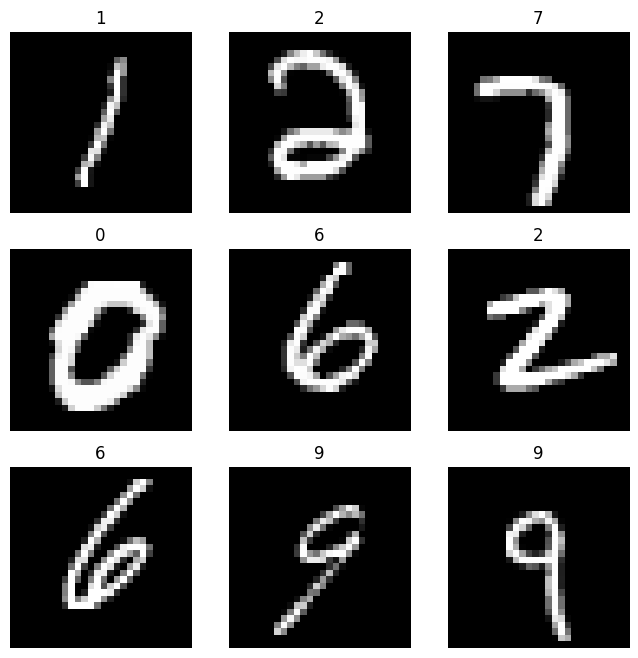

In [40]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



# Build Model #

### This time build autoencoder with convolutional Layers


In [41]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.dense = nn.Sequential(
                        nn.Linear(3136,2),
                        nn.ReLU())
        
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.conv1(x) # Output shape: torch.Size([1, 32, 14, 14])
        x = self.conv2(x) # Output shape: torch.Size([1, 64, 7, 7])
        x = self.flatten(x) # Output shape: torch.Size([1, 3136])
        x = self.dense(x) # Output shape: torch.Size([1, 2])
        return(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(2,3136),
            nn.ReLU()
        )
        self.transpconv1 = nn.Sequential(
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.transpconv2 = nn.Sequential(
                    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.output = nn.Sequential(
                    nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1,padding=0),
                    nn.Sigmoid())

    
    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 64, 7, 7 ) # Output shape: torch.Size([1, 64, 7, 7])
        x = self.transpconv1(x) # Output shape: torch.Size([1, 32, 14, 14])
        x = self.transpconv2(x) # Output shape: torch.Size([1, 32, 28, 28])
        x = self.output(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode = Encoder()
        self.decode = Decoder()


    def forward(self, x, return_latent=False):
        if return_latent:
            x = self.encode(x)
            latent = x.clone()
            x = self.decode(x)
            return x, latent
        else:
            x = self.encode(x)
            x = self.decode(x)
            return x


encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder() 

random_tensor = torch.randn(8,1,28,28)

print('encoder')
latent_test = encoder(random_tensor)
print('dencoder')

output_test = decoder(latent_test)

print('whole autoencoder')
whole_test = autoencoder(random_tensor)



encoder
dencoder
whole autoencoder


torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Model Output (untrained)')

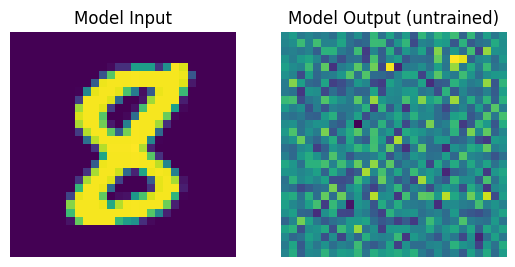

In [42]:
autoencoder = AutoEncoder() 

test_img, test_label = test_data[0]

print(test_img.shape)

test_pred = autoencoder(test_img.unsqueeze(0))

print(test_pred.shape)

fix,ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(test_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')

ax[1].imshow(np.squeeze(test_pred.detach().numpy()))
ax[1].axis('off')
ax[1].set_title('Model Output (untrained)')




# Traine Da Model #

Epoch [1/100], Train Loss: 0.0781, Validation Loss: 0.0665
Epoch [2/100], Train Loss: 0.0641, Validation Loss: 0.0630
Epoch [3/100], Train Loss: 0.0616, Validation Loss: 0.0615
Epoch [4/100], Train Loss: 0.0604, Validation Loss: 0.0606
Epoch [5/100], Train Loss: 0.0598, Validation Loss: 0.0598
Epoch [6/100], Train Loss: 0.0594, Validation Loss: 0.0595
Epoch [7/100], Train Loss: 0.0591, Validation Loss: 0.0593
Epoch [8/100], Train Loss: 0.0589, Validation Loss: 0.0592
Epoch [9/100], Train Loss: 0.0587, Validation Loss: 0.0591
Epoch [10/100], Train Loss: 0.0585, Validation Loss: 0.0588
Epoch [11/100], Train Loss: 0.0584, Validation Loss: 0.0589
Epoch [12/100], Train Loss: 0.0582, Validation Loss: 0.0587
Epoch [13/100], Train Loss: 0.0581, Validation Loss: 0.0584
Epoch [14/100], Train Loss: 0.0580, Validation Loss: 0.0585
Epoch [15/100], Train Loss: 0.0579, Validation Loss: 0.0582
Epoch [16/100], Train Loss: 0.0578, Validation Loss: 0.0581
Epoch [17/100], Train Loss: 0.0577, Validation Lo

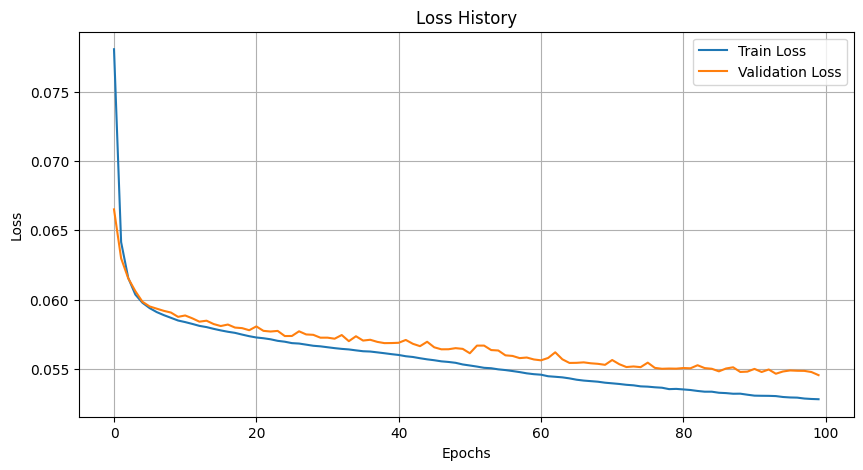

In [43]:
import matplotlib.pyplot as plt

# Initialize the model and move it to the configured device
autoencoder = AutoEncoder().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
 

# Number of epochs
epochs = 100

# Lists to store loss history for plotting
train_loss_history = []
validation_loss_history = []

# Training loop
for epoch in range(epochs):
    autoencoder.train()  # Set model to training mode
    running_loss = 0.0
    for images, _ in train_dataloader:
        images = images.to(device)  # Move images to the correct device

        # Forward pass
        outputs, _ = autoencoder(images, return_latent=True)
        
        # Loss calculation
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate and record the average training loss
    avg_train_loss = running_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)
    
    # Validation loop to check model performance on unseen data
    autoencoder.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)
            outputs, _ = autoencoder(images, return_latent=True)
            loss = criterion(outputs, images)
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_dataloader)
    validation_loss_history.append(avg_validation_loss)

    # Step the learning rate scheduler

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
torch.save(autoencoder.state_dict(), 'autoencoder.pth')


torch.Size([1, 28, 28])


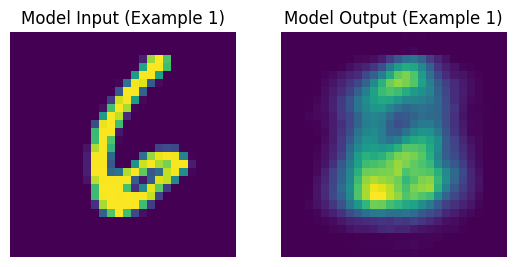

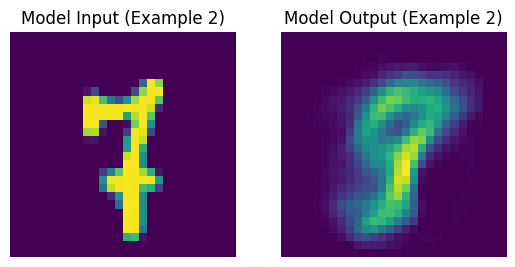

[[[[ 2.70791439e-04  1.67424776e-06  1.06289451e-06  2.17533398e-05
     7.84608201e-05  3.57599813e-04  1.88069534e-04  2.29402853e-04
     4.61181335e-04  6.67992805e-04  6.88068627e-04  1.47770531e-03
     5.88749128e-04  8.84246314e-04  4.67482198e-04  5.84412925e-03
     5.23204682e-03  6.20794902e-03  1.63644587e-03  1.54930621e-03
     1.10516604e-03  1.21498224e-03  3.58394522e-04  2.60710047e-04
     2.21568131e-04  1.64325698e-04  6.81858364e-05  1.40070904e-03]
   [ 3.50428138e-07  1.43424042e-12  3.38438782e-12  9.50952581e-11
     2.10756679e-09  3.67067003e-07  1.06595473e-06  6.88955595e-07
     3.05463504e-06  3.63786307e-06  9.43905616e-06  1.20003358e-06
     3.02703256e-06  4.02233400e-06  1.00385769e-05  1.46819410e-04
     2.93791061e-04  3.84643608e-05  2.34427444e-05  2.36907408e-06
     1.58415014e-06  7.03048158e-07  4.82736652e-07  1.56503617e-07
     7.75111516e-07  1.53275067e-07  7.44000630e-08  2.85071383e-06]
   [ 2.66716768e-07  3.07632322e-11  1.1356925

In [53]:

ri = np.random.randint(0, 5000, size=2)
 
# Assuming AutoEncoder and training_data are already defined and available in the context
model = AutoEncoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the first example from the training data
examp_img_1, examp_label_1 = training_data[ri[0]]
examp_img_device_1 = examp_img_1.to(device)

print(examp_img_device_1.shape)
examp_output_1 = model(examp_img_device_1.unsqueeze(0))
examp_output_cpu_1 = examp_output_1.cpu().detach().numpy()

# Load the second example from the training data
examp_img_2, examp_label_2 = training_data[ri[1]]
examp_img_device_2 = examp_img_2.to(device)

examp_output_2 = model(examp_img_device_2.unsqueeze(0))
examp_output_cpu_2 = examp_output_2.cpu().detach().numpy()



# Plot the first example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(np.array(examp_img_1)))
ax[0].axis('off')
ax[0].set_title('Model Input (Example 1)')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_1)), (28, 28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Example 1)')

# Plot the second example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(np.array(examp_img_2)))
ax[0].axis('off')
ax[0].set_title('Model Input (Example 2)')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_2)), (28, 28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Example 2)')

plt.show()

print(examp_output_cpu_1 - examp_output_cpu_2)